# Table of contents

### [Objectives](#I)

### [Creating the database](#T1)

### [Testing the different embeddings](#T2)
- [Free of charge: all-MiniLM-l6-v2 ](#T2C1)
- [Low token price: VoyageAI: voyage-02](#T2C2)
- [openAI: text-embedding-3-small](#T2C3)

### [Reranking](#T3)

### [Small-to-Big](#T4)

### [Rephrased question](#T5)



***
# <a name="I">Objectives</a>

This notebook aims to enhance the efficiency of text generation by implementing Retrieval Augmented Generation (RAG). 

Retrieval Augmented Generation (RAG) is a powerful methodology designed to enhance the contextual relevance and accuracy of generative text models. The primary objective of RAG is to overcome the limitations of conventional text models, which are often trained on static datasets and might not reflect the most recent information.

To implement RAG, a crucial step involves creating a comprehensive database of texts. Each text within this database is vectorized using an embedder, employing matrices of varying dimensions ranging from 300 to 1500. This vectorization process encapsulates the semantic essence of each text, transforming it into a numerical representation that captures its contextual relationships and nuances.

Upon receiving a user query, the RAG system uses the same embedder to vectorize the query, placing it in the same semantic space as the database texts. This allows for a meaningful comparison of similarities between the user query and the texts within the database. The RAG system then identifies and retrieves the most similar texts based on this semantic proximity.

These retrieved texts play a crucial role as contextual information for the generative text model. Instead of relying solely on pre-existing training data, the generative model now leverages the dynamically acquired context from the database. This dynamic contextualization empowers the model to generate responses that are not only informed by the original training but are also grounded in the most relevant and up-to-date information available in the database.

In summary, RAG combines the strengths of retrieval and generation approaches by employing an embedder to create a database of vectorized texts. This enables the system to dynamically retrieve contextually relevant information in response to user queries, thereby enhancing the generative text model's ability to provide accurate and current responses.

Throughout the notebook, various techniques will be explored to optimize the retrieval process, ensuring the generative model is fed with accurate and contextually relevant data.


***
# <a name="T1">Creating the database</a>

Nutritional AI and for our used case here, we will use AstraDB from Datastax.

DataStax is a company known for providing distributed database management systems based on Apache Cassandra. Cassandra is an open-source NoSQL database known for its ability to handle large amounts of data.

**Advantages**: Free of charge for most cases, easy to use.

**Disadvantage**: Not the easiest documentation.


Following the guide from Datastax to create your database and multiple collections for the test.

In [ ]:
# We put the token and endpoint in env
# export ASTRA_DB_API_ENDPOINT=ENDPOINT_API
# export ASTRA_DB_API_TOKEN=ASTRA_DB_TOKEN

In [15]:
# We install the libraries
pip install astrapy pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os

from astrapy.db import AstraDB

# Initialize the client.

db = AstraDB(
    token=os.environ["ASTRA_DB_API_TOKEN"],
    api_endpoint=os.environ["ASTRA_DB_API_ENDPOINT"],
)

Populate the database with the searchs:

- [catechin];[microbiota]
- [apple,catechin,gut microbiota,polyphenols,fruits,green tea,sugar,lipids,liver,dietary fiber,proteins,sport,muscle,cancer,death,epicatechin,nutrition]


By using bash_generator.py, i generated 3 collections using the embedder:
- **openai**: text-embedding-3-small / 1536 dimensions
- **voyageai**: voyage-02 / 1024 dimension
- **free-embedder**: sentence-transformers/all-MiniLM-l6-v2 / 384 dimensions



***
# <a name="T2">Testing the different embeddings</a>

In [3]:
from astrapy.db import AstraDBCollection
import pandas as pd

def preparation_data(astra_db, collection_name):
    # Access an existing collection
    collection = AstraDBCollection(collection_name=collection_name, astra_db=astra_db)
    
    # We create a generator to have access to the database
    generator = collection.paginated_find()
    
    # We loop inside the generator to retrieve the data
    file = [doc for doc in generator]
    
    # We create a DataFrame
    df_file = pd.DataFrame(file, columns=['_id', 'content', '$vector', 'metadata'])
    
    # Create new columns for metadata column
    df_file['PmID'] = df_file['metadata'].apply(lambda x: x['PmID'])
    df_file['Title'] = df_file['metadata'].apply(lambda x: x['Title'])
    df_file['Publication_Date'] = df_file['metadata'].apply(lambda x: x['Publication_Date'])
    df_file['Authors'] = df_file['metadata'].apply(lambda x: x['Authors'])
    df_file['Journal'] = df_file['metadata'].apply(lambda x: x['Journal'])
    df_file['DOI'] = df_file['metadata'].apply(lambda x: x['DOI'])
    df_file['Query'] = df_file['metadata'].apply(lambda x: x['query'])
    
    # Drop the original column metadata
    df_file = df_file.drop('metadata', axis=1)
    
    # To clean-up the query terms
    df_file["Query"] = df_file["Query"].str.replace("[mesh]", "")
    df_file["Query"] = df_file["Query"].str.replace("+AND+", ", ")

    # We return the dataframe
    return df_file   

In [4]:
from sklearn.manifold import TSNE
import numpy as np
from sklearn import cluster, metrics
import matplotlib.pyplot as plt
import seaborn as sns

def tsne_plot(df, embedding):
    df_file = df.copy()

    # We transform the vector
    df_file['$vector'] = df_file['$vector'].apply(np.array)

    # We create the TSNE object
    tsne = TSNE(n_components=2, 
                random_state=42, 
                init = "random", 
                perplexity = 50, 
                learning_rate = 200, 
                n_iter = 1000)

    # We fit_transform
    X_tsne = tsne.fit_transform(np.vstack(df_file['$vector']))

    # We also want to compare the result and separation
    # We use Kmeans to clusterize
    n_clusters = len(df_file["Query"].unique())
    cls = cluster.KMeans(n_clusters = n_clusters, 
                         init = "k-means++", 
                         random_state=42)
    
    # We fit on the data
    cls.fit(X_tsne)
    
    # We calculate the ARI score
    true_labels = df_file["Query"]
    ARI = np.round(metrics.adjusted_rand_score(true_labels, cls.labels_), 3)
    
    # We add the labels
    tsne_result = np.column_stack((X_tsne, true_labels))
    
    # We add the predicteed labels
    tsne_result = np.column_stack((tsne_result, cls.labels_))

    # We transform to a dataframe
    pd_tsne = pd.DataFrame(tsne_result, columns = ["x", "y", "True labels", "Predicted labels"]).sort_values("True labels")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    palette = sns.color_palette("husl", n_colors=n_clusters)
    
    # We show the results with the True labels and Predicted labels
    for ax, labels in zip(axes, ["True labels", "Predicted labels"]):
        scatter = sns.scatterplot(data = pd_tsne, x = pd_tsne.x, y=pd_tsne.y, hue=labels, palette=palette, ax=ax)
        ax.set_xlabel('t-SNE Dimension 1')
        ax.set_ylabel('t-SNE Dimension 2')
        ax.set_title(f't-SNE representation of Data with embedding: {embedding} \nARI score: {ARI}, {labels}')
        ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), borderaxespad=0)
    
    plt.show()

### <a name="T2C1">Free of charge: all-MiniLM-l6-v2</a>

In [6]:
df_MiniLM = preparation_data(db, "sc_article_nutrition_hf_4")

print(df_MiniLM.value_counts("Query"))

Query
apple                   104
catechin, microbiota     98
catechin                 98
gut microbiota           97
polyphenols              96
fruits                   90
green tea                90
sugar                    86
lipids                   79
liver                    79
dietary fiber            78
proteins                 78
sport                    76
muscle                   71
cancer                   53
death                    43
epicatechin              27
nutrition                 4
Name: count, dtype: int64


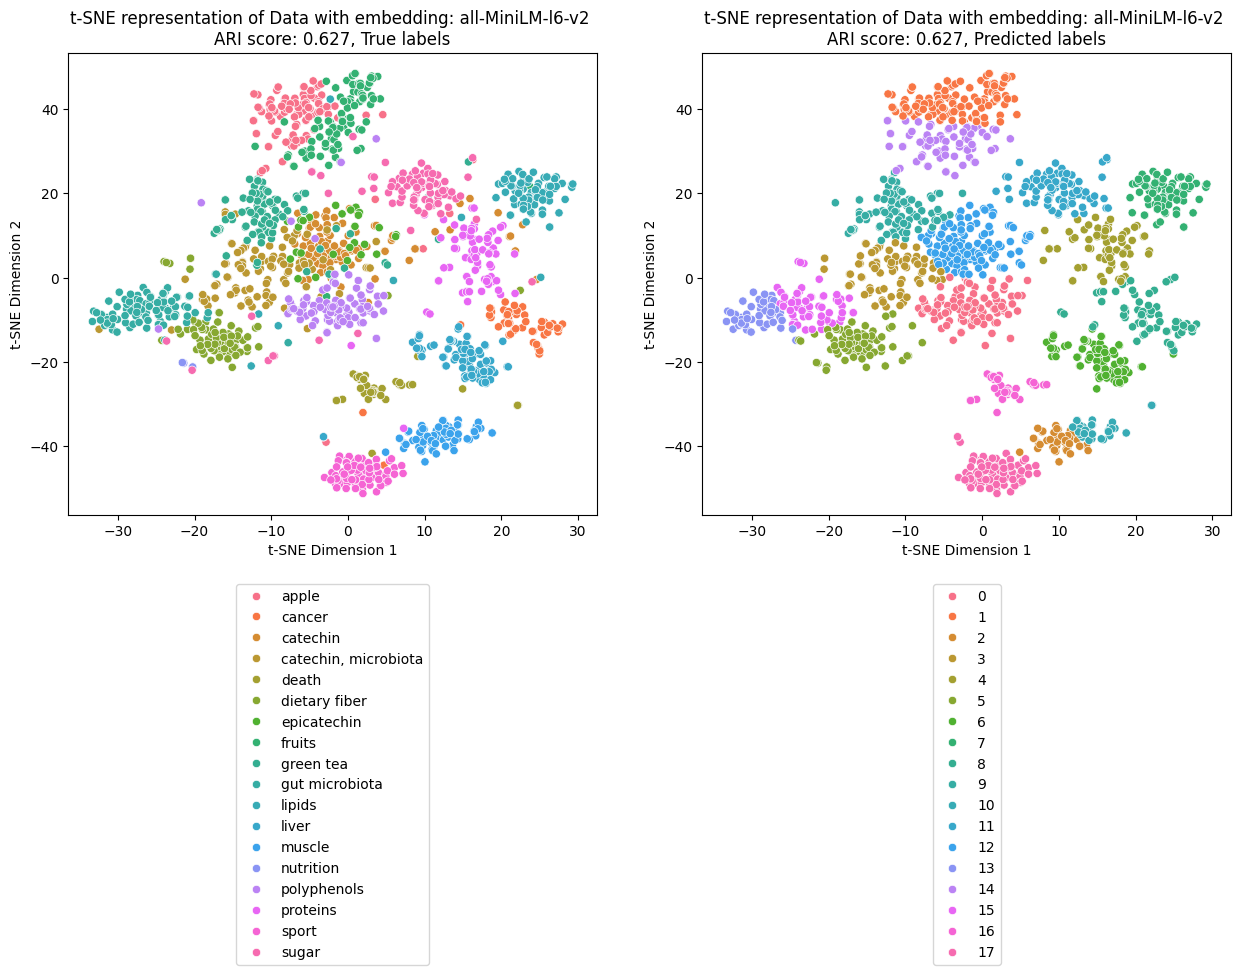

In [7]:
tsne_plot(df_MiniLM, "all-MiniLM-l6-v2")

### <a name="T2C2">Low token price: VoyageAI: voyage-02</a>

In [4]:
df_voyageai = preparation_data(db, "sc_article_nutrition_hf_5")

print(df_voyageai.value_counts("Query"))

Query
apple                   104
catechin, microbiota     99
gut microbiota           97
catechin                 97
polyphenols              96
fruits                   90
green tea                90
sugar                    86
lipids                   79
liver                    79
dietary fiber            78
proteins                 78
sport                    75
muscle                   71
cancer                   53
death                    43
epicatechin              27
nutrition                 4
Name: count, dtype: int64


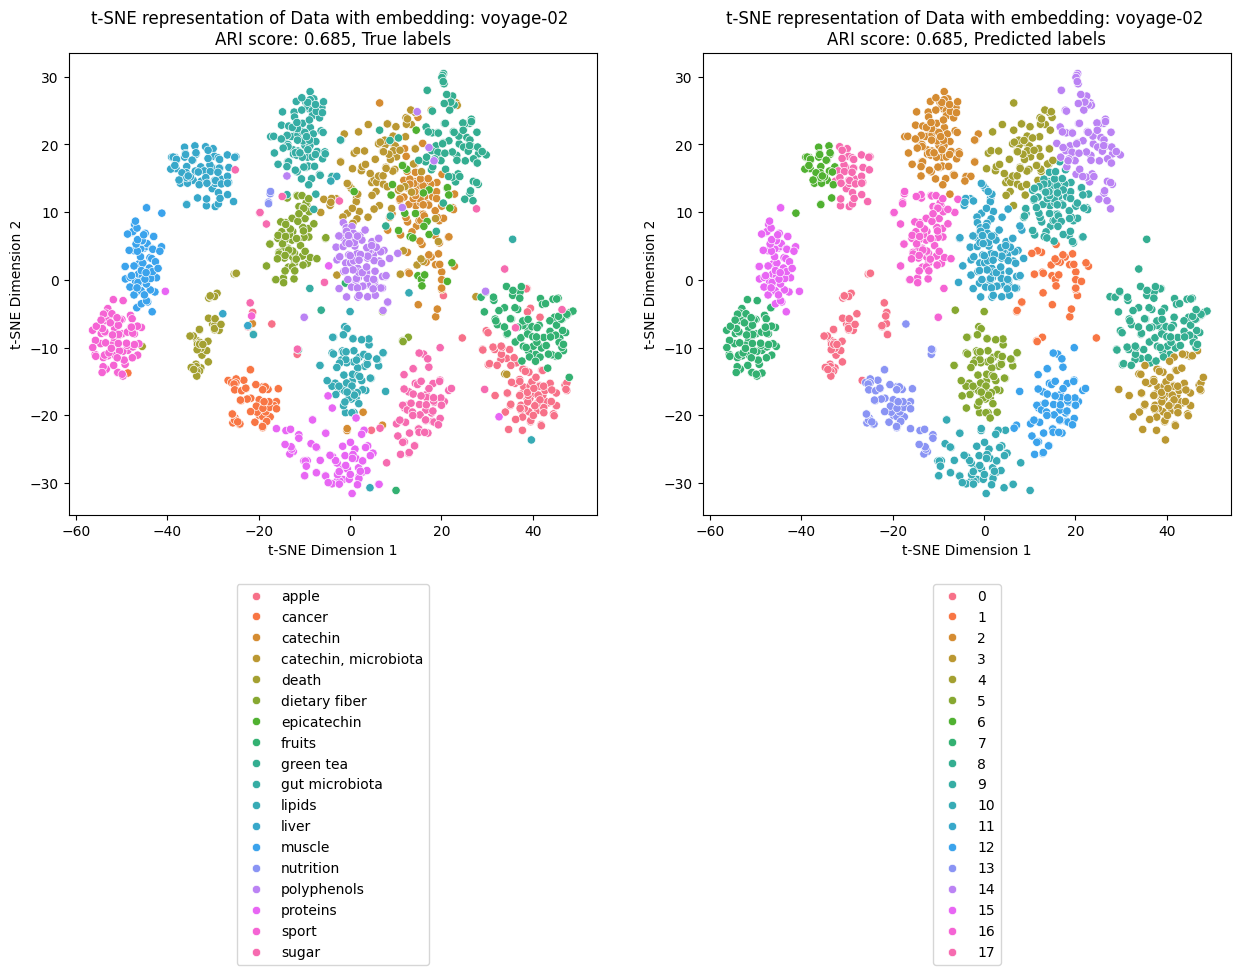

In [10]:
tsne_plot(df_voyageai, "voyage-02")

### <a name="T2C3">openAI: text-embedding-3-small</a>

In [8]:
df_openai = preparation_data(db, "sc_article_nutrition_hf_6")

print(df_openai.value_counts("Query"))

Query
apple                   104
catechin, microbiota     99
gut microbiota           97
catechin                 97
polyphenols              96
fruits                   90
green tea                90
sugar                    86
lipids                   79
liver                    79
dietary fiber            78
proteins                 78
sport                    75
muscle                   71
cancer                   53
death                    43
epicatechin              27
nutrition                 4
Name: count, dtype: int64


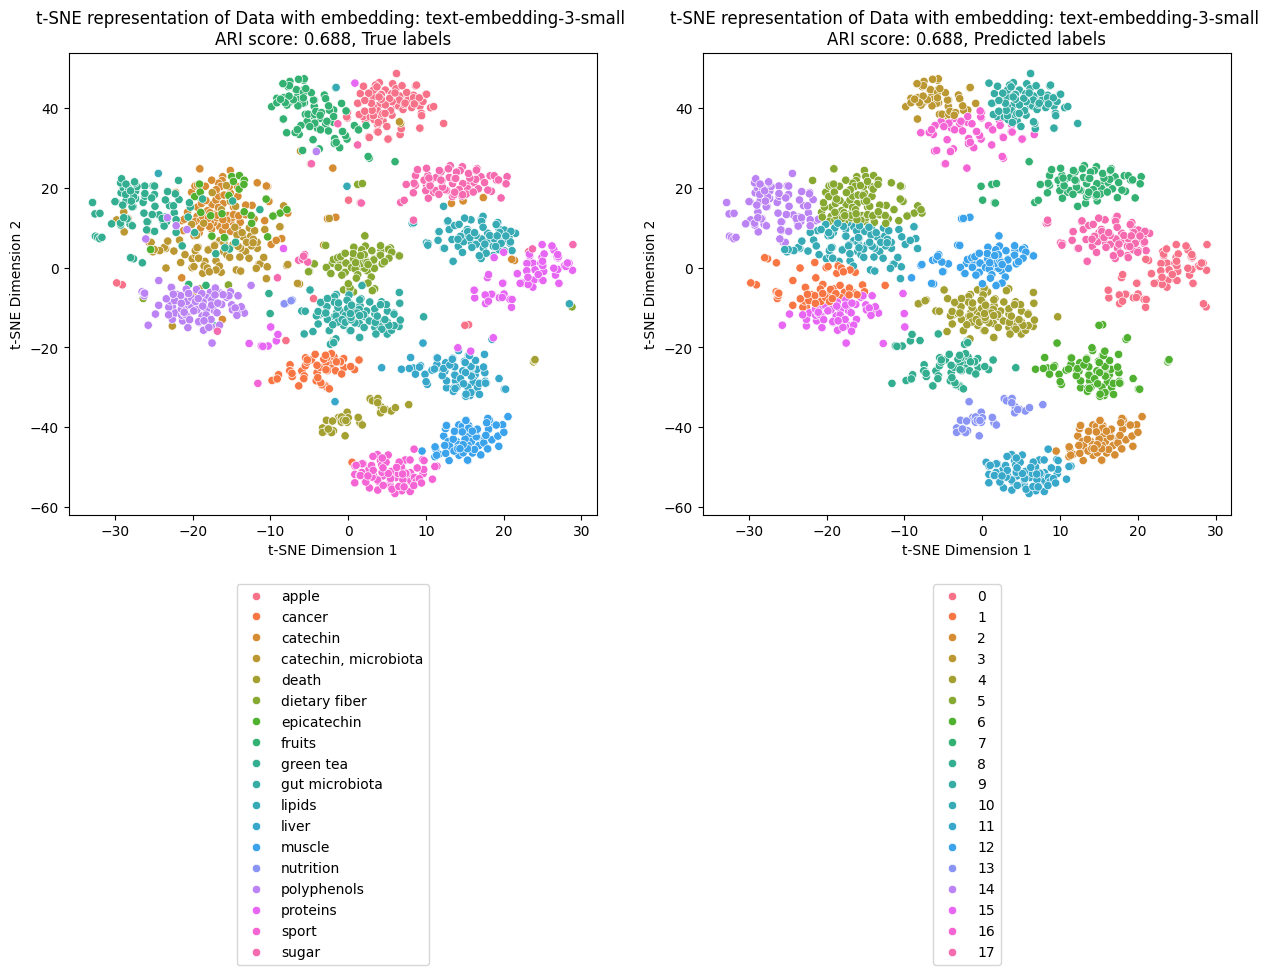

In [9]:
tsne_plot(df_openai, "text-embedding-3-small")

On a few article abstracts, we can show difference in embeddings results. 

The free to use embedding solution "all-MiniLM-l6-v2" shows able separation with less dimensions.

Recent embedded models from voyageAI and openAI show better separation.

voyage-2 model is a good alternative to text-embedding-3-small, as they present similar results.

Taking into consideration voyage-2 free used of 50M tokens, for a small application it is quite viable.

If we wanted a more extensive test, we would repeat it with other queries.

***
# <a name="T3">Rekanking</a>

In the context of retrieval augmented generation (RAG), re-ranking refers to the process of selecting and prioritizing retrieved documents or passages based on their relevance to the given query. The primary goal of re-ranking is to improve the quality of the retrieved information and enhance the overall performance of the generative text model.

**Enhancing Relevance**: The initial retrieval process might return a set of documents or passages that are relevant to the query, but they might not be ordered by their level of relevance. Re-ranking aims to reorder the retrieved results, placing the most relevant information at the top. 

It is important for generative text models, as the informations from the top are less likely lost.

In [2]:
from langchain_community.embeddings import VoyageEmbeddings
from langchain_community.vectorstores import AstraDB

embeddings = VoyageEmbeddings(voyage_api_key=os.environ["VOYAGE_API_KEY"],
                                      model = "voyage-02")
        
# Connection to the Vector Store
vector_store = AstraDB(
    embedding=embeddings,
    collection_name="sc_article_nutrition_hf_5",
    api_endpoint=os.environ["ASTRA_DB_API_ENDPOINT"],
    token=os.environ["ASTRA_DB_API_TOKEN"]
)

In [4]:
# Some questions
questions = ["How can I incorporate more protein into my vegetarian diet?", 
             "Can you suggest high-fiber foods for better gut health?",
            "How can I incorporate more antioxidants into my diet?"]

In [7]:
for question in questions:
    # We search bor the 10 best sources
    sources = vector_store.similarity_search(question, k=10)

    # We extract the article title
    titles = list(set([doc.metadata.get('Title') for doc in sources]))
    
    print("Question:")
    print(question)

    for i, title in enumerate(titles):
        print(f"- Article {i+1}: {title}")
    
    print("\n")

Question:
How can I incorporate more protein into my vegetarian diet?
- Article 0: Competitive interactions among tea catechins, proteins, and digestive enzymes modulate in vitro protein digestibility, catechin bioaccessibility, and antioxidant activity of milk tea beverage model systems.
- Article 1: [Genome-wide identification and effect of 
- Article 2: Role of dietary fiber in the recovery of the human gut microbiome and its metabolome.
- Article 3: Solubility and secretability.
- Article 4: An Overview of Current Methods to Confirm Protein-Protein Interactions.
- Article 5: The lipids in human milk.
- Article 6: Effects of theabrownin on serum metabolites and gut microbiome in rats with a high-sugar diet.
- Article 7: Key Physicochemical Characteristics Influencing ADME Properties of Therapeutic Proteins.
- Article 8: Overview of the physical state of proteins within cells.
- Article 9: Revenant: a database of resurrected proteins.



Question:
Can you suggest high-fiber foods for

We use the library cohere.

It uses a large language model to compute a relevance score for each document in the initial search results.

Rerank significantly improves search results, especially for complex queries.

In [3]:
import cohere

# init client
co = cohere.Client(os.environ["COHERE_API_KEY"])

In [11]:
def reranking_question(question):
    sources = vector_store.similarity_search(question, k=10)

    abstract = [doc.page_content for doc in sources]
    
    rerank_docs = co.rerank(
        query=question, documents=abstract, top_n=10, model="rerank-english-v2.0"
    )
    
    for i, re_rank_files in enumerate(rerank_docs):
        print(f"Previous rank [{re_rank_files.index}] -> new rank [{i}] with score: {re_rank_files.relevance_score}" )
        print("Abstract: ")
        print(re_rank_files.document['text'])
        print()

In [4]:
question = "How can I incorporate more protein into my vegetarian diet?"

reranking_question(question)

In [10]:
question = "Can you suggest high-fiber foods for better gut health?"

reranking_question(question)

Previous rank [2] -> new rank [0] with score: 0.9580695
Abstract: 
Dietary fiber has received considerable attention in both the popular press and the scientific literature. Fiber is a complex mixture of substances, and research on its effects is difficult to interpret. Dietary fiber has significant gastrointestinal effects, and it is a mainstay of treatment for constipation and hemorrhoids. Insoluble fiber, such as wheat bran, is most effective for treatment of these conditions. Increased intake of soluble dietary fiber appears to benefit patients with diabetes mellitus and hyperlipidemia. High-fiber, low-fat diets have been recommended by a variety of authorities to decrease the incidence of heart disease and certain types of cancer. Any increase in dietary fiber intake should be accompanied by an increase in water intake.

Previous rank [4] -> new rank [1] with score: 0.93663365
Abstract: 
During the last 18 years, considerable research has been conducted on the role of dietary fibe

In [12]:
question = "How can I incorporate more antioxidants into my diet?"

reranking_question(question)

Previous rank [5] -> new rank [0] with score: 0.8887588
Abstract: 
Cardiovascular diseases (CVD) are the leading cause of mortality worldwide. It is widely accepted that oxidative stress plays a key role in their development and progression; hence oxidative damage might be abrogated by antioxidants. Polyphenols are phytochemicals showing extensively studied antioxidant properties in-vivo. Most representative sources of these compounds include fruits, greens, nuts, herbs, cocoa, tea and coffee. Epidemiological evidence suggests an association between the consumption of polyphenol-rich vegetables and the reduction of cardiovascular disease prevalence. This fact could be related to the anti-inflammatory, antithrombotic and vasodilatory effects of polyphenols. Even though these biological effects could be mainly attributed to the antioxidant activity of polyphenols, other pharmacological mechanisms should also be considered. The latter could comprise direct anti-inflammatory effects, modul

***
# <a name="T4">Small-to-Big</a>

When we created the database, we cut some of the  abstracts.

By reconstructing the full abstract, it is possible to have more informations.

In [135]:
def small_to_big(collection, documents):
    """
    Return full documents after first extraction
    args:
        collection: The collection we use
        documents: documents that were extracted with the first step
    """
    
    # We extract the PmID from the documents
    PmID_full_sources = [document.metadata.get("PmID") for document in documents]
    
    # We eliminate duplicatas
    PmID_full_sources = list(set(PmID_full_sources))
    
    # To store the new documents
    full_documents = []
    
    # We look through the PmIDs
    for article_PmID in PmID_full_sources:
        # We retrieve all documents linked to the PmID
        chunk = collection.find({"metadata.PmID": article_PmID})
        # We reduce to one document with the full abstract
        
        if len(chunk['data']['documents']) > 1:
            chunk = reduce_document(chunk)
        
        # We extend the full_documents
        full_documents.append(chunk)

    return full_documents

def return_abtracts_from_documents(documents):
    """
    We return the abstracts in a list
    """
    try:
        return [document.page_content for document in documents]
    except:
        try:
            return documents.page_content
        except:
            try:
                return [doc['content'] for document in documents for doc in document['data']['documents']]
            except:
                try:
                    return [document['content'] for document in documents['data']['documents']]
                except:
                    return []

def reduce_document(documents):
    """
    To combine abstracts from the same PmID
    """
    # We use the first chunks as the base line
    clean_chunk = {'data':{'documents':[documents['data']['documents'][0]]}}
    
    # We extract all the chunks abstracts
    abstracts = return_abtracts_from_documents(documents)
    
    # We modify the abstract with the concatenate version
    clean_chunk['data']['documents'][0]['content'] = ','.join(abstracts)
        
    # We return it
    return clean_chunk

def reranker_abstracts(query, documents, th=0.5, k=None, coherence_key = os.environ["COHERE_API_KEY"]):
    """
    We rerank the abstracts. 
    It can improve the selection of pertinent texts
    """
    
    # init client
    co = cohere.Client(coherence_key)
    
    # We extract the abstracts
    abstracts = return_abtracts_from_documents(documents)
    
    k = k if k else len(abstracts)
    
    rerank_docs = co.rerank(
        query=query, 
        documents=abstracts, 
        top_n=k, 
        model="rerank-english-v2.0"
    )
    
    # To store the new re ranked document
    reranked_documents = []
    
    # We loop through the document
    for re_rank_files in rerank_docs:
        
        # If superior to the threshold we keep it
        if re_rank_files.relevance_score > th:
            
            reranked_documents.append(documents[re_rank_files.index])
    
    # We return the reranked documents
    return reranked_documents
    

In [141]:
sources = vector_store.similarity_search(question, k=10)

initial_abstracts = return_abtracts_from_documents(sources)

# We search for full abtract
full_documents = small_to_big(collection, sources)

intermediate_abstracts = return_abtracts_from_documents(full_documents)

# We rerank the documents and eliminate not pertinent ones
reranked_documents = reranker_abstracts(question, full_documents)

# We retrieve the final abstracts
final_abstracts = return_abtracts_from_documents(reranked_documents)

In [142]:
print("Initial number of documents:", len(initial_abstracts))

print("Final number of documents:", len(final_abstracts))

Initial number of documents: 10
Final number of documents: 8


In [134]:
question

'How can I incorporate more antioxidants into my diet?'

In [133]:
initial_abstracts

['Polyphenols, members of phytochemical superfamily rich in vegetables and fruits, include flavonoids, non-flavonoids, and phenolic acids. Their biological effects includes classical antioxidation (e.g., radical-scavenging, metal chelating, NOX inhibition, attenuation on mitochondrial respiration, inhibition on xanthine oxidase, and upregulations on endogenous antioxidant enzymes), multiple regulations on cell signaling (e.g., AMPK activation, SirT1 activation, eNOS activation, FOXO activation, NFκB inactivation, PI3K/AkT inhibition, mTORC1 inhibition, PKC inhibition, MAPK inhibition, ERK inhibition, JAK/STAT inhibition, IKK/JNK inhibition, PDE inhibition, β-catenin inactivation, downregulation on TLR expression, ACE inhibition, adiponectin elevation, attenuated ET-1 production, and K+ channel activation), and many other actions (e.g., inhibition on α-glucosidase, anticoagulation, γ-secretase inhibition, monoamine oxidase inhibition, LPL upregulation, ANGPTL4 suppression, upregulation 

In [131]:
final_abstracts

# We see the new order and with deleted non pertinent ones.

['Cardiovascular diseases (CVD) are the leading cause of mortality worldwide. It is widely accepted that oxidative stress plays a key role in their development and progression; hence oxidative damage might be abrogated by antioxidants. Polyphenols are phytochemicals showing extensively studied antioxidant properties in-vivo. Most representative sources of these compounds include fruits, greens, nuts, herbs, cocoa, tea and coffee. Epidemiological evidence suggests an association between the consumption of polyphenol-rich vegetables and the reduction of cardiovascular disease prevalence. This fact could be related to the anti-inflammatory, antithrombotic and vasodilatory effects of polyphenols. Even though these biological effects could be mainly attributed to the antioxidant activity of polyphenols, other pharmacological mechanisms should also be considered. The latter could comprise direct anti-inflammatory effects, modulation of intracellular signaling and gene expression, improvement

In this case, the abstracts were not cut.

In others, it showed the retrieved  full abstracts

***
# <a name="T5">Rephrased question</a>